In [29]:
import torch
import pandas as pd
import numpy as np
import string
import re
from skimage.io import imread, imshow
from skimage import color
from skimage.transform import resize
from PIL import Image, ImageOps
import torch.nn as nn
import torch.optim as optim
import os
import PIL
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


READING CSV

In [31]:
df=pd.read_csv("/content/drive/MyDrive/memotion_dataset_7k/labels.csv")


Filling NAN VALUES IN TEXT CORRECTED

In [32]:
df['text_corrected'].fillna('',inplace=True)

PREPROCESSING OF TEXT

In [33]:
a=df['text_corrected']
c=0
array=[]

stopwords = nltk.corpus.stopwords.words('english')
for text in df['text_corrected']:
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    c+=1
    text=punctuationfree.lower()
    text=re.split(' ',text)
    text=[i for i in text if i not in stopwords]
    ff=""
    for i in text:
        ff=ff+i+" "
    text=ff
    array.append(text)
    

GENERATING A VOCABULARY WHICH ASSIGNS EACH WORD A UNIQUE NUMBER WITH WHICH IT CAN BE REPRESENTED

In [34]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')
train_iter = array

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1
newarr=[]
for i in range(len(array)):
    abc=text_pipeline(array[i])
    newarr.append(abc)



GETTING INDEX OF EACH TEXT THAT HAS NO VALUE IN IT 

In [35]:
ad=[]

for i in range(len(newarr)):
    if(len(newarr[i])==0):
        ad.append(i)
ad.append(5118)
for i in range(len(ad)):
    newarr.remove(newarr[ad[i]])
ad

[119, 658, 3257, 4463, 4531, 4663, 4799, 5411, 6781, 6784, 6786, 5118]

DROPPING THE ROWS THAT HAVE NO VALUES

In [36]:
df.drop(labels=ad,axis=0,inplace=True)

In [37]:
df['overall_sentiment']

0       very_positive
1       very_positive
2            positive
3            positive
4             neutral
            ...      
6987          neutral
6988          neutral
6989         positive
6990    very_positive
6991         positive
Name: overall_sentiment, Length: 6980, dtype: object

READING AND STORING IMAGES

In [38]:
path="/content/drive/MyDrive/memotion_dataset_7k/images"
#for j in os.listdir(path):
#    print(j)
LOAD_TRUNCATED_IMAGES = True
tempimg=[]
from PIL import Image
for j in (df["image_name"]):
# creating a object
    im = Image.open(path+'/'+j)
    newsize = (256, 256)
    im=im.resize(newsize)
    im=ImageOps.grayscale(im)
    im=np.array(im)
    im=im.flatten()
    tempimg.append(im)



/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


PADDING AND MAKING THE TEXT LIST BALENCED

In [39]:
for i in range(len(newarr)):
    max=106
    fa=len(newarr[i])
    total=max-fa
    for j in range(total):
        newarr[i].append(0)


In [40]:
X_train=tempimg[:4886]
X_test=tempimg[4886:]
X_train1=newarr[:4886]
X_test1=newarr[4886:]
X_train1=np.array(X_train1)
X_test1=np.array(X_test1)

In [41]:
df['overall_sentiment'].value_counts()
order={"positive":2,"neutral":1,"very_positive":2 ,"negative":0,"very_negative":0}
df['overall_sentiment']=df['overall_sentiment'].map(order)
Y=df['overall_sentiment']
y=[]
for i in Y:
    y.append(i)
y_train=y[:4886]
y_test=y[4886:]
y_train=np.array(y_train)
y_test=np.array(y_test)
y_train


array([2, 2, 2, ..., 2, 0, 1])

In [42]:
X_train=torch.tensor(X_train)
X_test=torch.tensor(X_test)
y_train=torch.tensor(y_train)
y_test=torch.from_numpy(y_test)
X_train1=torch.from_numpy(X_train1)
X_test1=torch.from_numpy(X_test1)
y_train
#4886


tensor([2, 2, 2,  ..., 2, 0, 1])

In [43]:
def valreturner(x):
    image=X_train[x].float()
    text=X_train1[x].float()
    label=y_train[x]
    label=label
    return image, text, label

In [44]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.Text = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(106, 512),
            nn.Sigmoid(),
            nn.Linear(512, 512),
            nn.Sigmoid(),
            nn.Linear(512, 512),
            nn.Sigmoid(),
            nn.Linear(512, 512),
            nn.Sigmoid(),
            nn.Linear(512, 128),
        )
        self.Image = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256*256, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
        )
        
        
        self.Final = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Sigmoid(),
            nn.Linear(512, 3),
        )

    def forward(self, image, text):
        text = self.Text(text)
        image = self.Image(image)
        concat = torch.cat([text,image],0)
        output = self.Final(concat)
        return output

In [45]:
clf = NeuralNetwork()

In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(clf.parameters(), lr=0.08,betas=(0.9, 0.999), eps= 1e+20)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')

In [26]:
for epoch in range(2): 
    running_loss = 0.0
    correct = 0
    size=(len(X_train))
    for i in range(size):
        im, t, la = valreturner(i)
        optimizer.zero_grad()
        output = clf(im, t)
        if output.argmax(0) == la:
            correct += 1
        loss = criterion(output, la)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 500 == 499:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 500:.3f}')
            running_loss = 0.0
        scheduler.step(loss)
    print(correct/ size)
    correct =0 
print('Finished Training')


[1,   500] loss: 0.961
[1,  1000] loss: 0.963
[1,  1500] loss: 0.976
[1,  2000] loss: 0.962
[1,  2500] loss: 0.977
[1,  3000] loss: 0.967
[1,  3500] loss: 0.978
[1,  4000] loss: 0.979
[1,  4500] loss: 0.955
0.5923045435939419
[2,   500] loss: 0.961
[2,  1000] loss: 0.963
[2,  1500] loss: 0.976
[2,  2000] loss: 0.963
[2,  2500] loss: 0.977
[2,  3000] loss: 0.967
[2,  3500] loss: 0.978
[2,  4000] loss: 0.979
[2,  4500] loss: 0.955
0.5923045435939419
Finished Training


In [47]:
import torch
from torch import nn
%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot, make_dot_from_trace

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/szagoruyko/pytorchviz.git (to revision master) to /tmp/pip-req-build-5kz1jp1u
  Running command git clone -q https://github.com/szagoruyko/pytorchviz.git /tmp/pip-req-build-5kz1jp1u


In [49]:
im, t, la = valreturner(0)

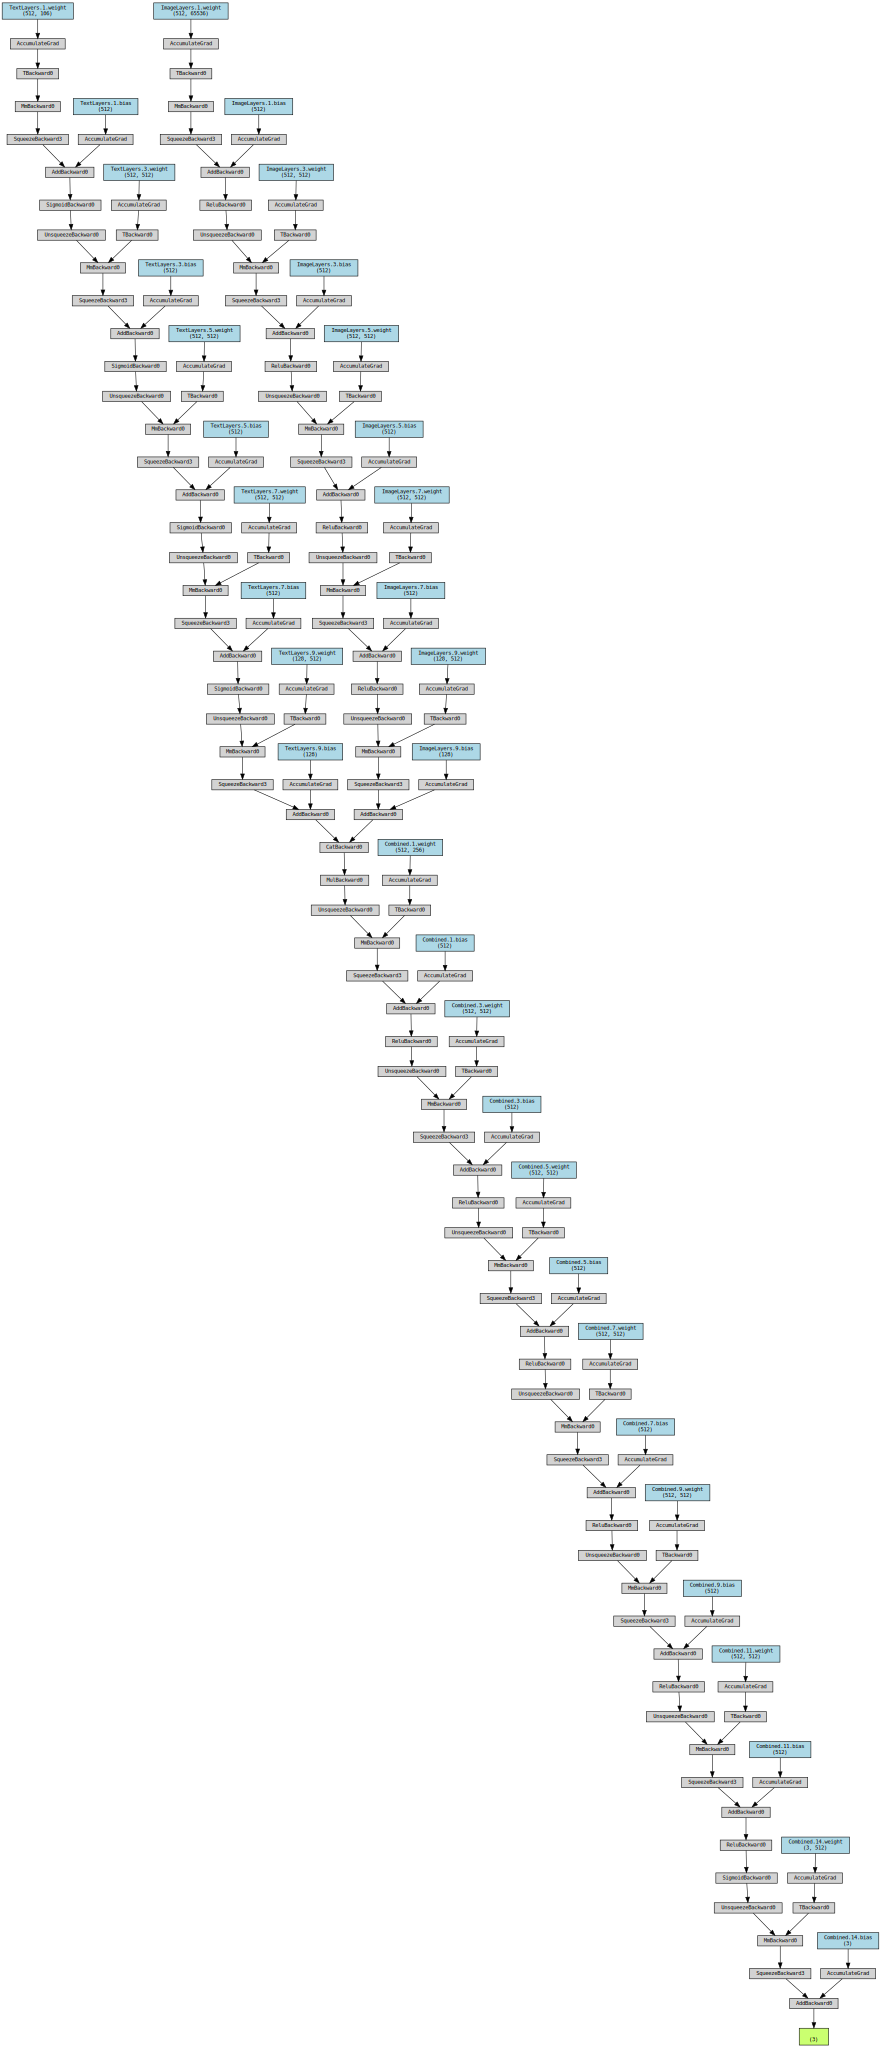

In [50]:
make_dot(clf(im, t), params=dict(clf.named_parameters()))